In [2]:
import multiprocessing as mp

from scipy.spatial.transform import Rotation as R
import numpy as np
import math
import matplotlib.pyplot as plt
#from sympy import Point, Line

#from Geometry3D import *

import Geometry3D as geo

import time
import os

import cv2
from PIL import Image

import SimpleITK as sitk
from torchio.transforms import Affine
from torchio import Image

from pathlib import Path

from bs4 import BeautifulSoup
import json

import pandas as pd

In [157]:
def read_crop_info(file_name):
    
    with open(file_name, "r") as fp:
        crop_info = json.load(fp)
        
    return crop_info

def read_rotation_info(file_name):
    
    with open(file_name, "r") as fp:
        rot = json.load(fp)
        
        
        #rotation_info = {'x_dir': {'x': x_dir.getX(), 'y': x_dir.getY(), 'z': z_dir.getZ()},
        #             'y_dir': {'x': y_dir.getX(), 'y': y_dir.getY(), 'z': y_dir.getZ()},
        #             'z_dir': {'x': z_dir.getX(), 'y': z_dir.getY(), 'z': z_dir.getZ()}
        #            }
        
    x = [rot['x_dir']['x'], rot['x_dir']['y'], rot['x_dir']['z']]
    y = [rot['y_dir']['x'], rot['y_dir']['y'], rot['y_dir']['z']]
    z = [rot['z_dir']['x'], rot['z_dir']['y'], rot['z_dir']['z']]
    
  
    return x,y,z

def read_mitk_landmarks(file_name, scale=1.0, mode='def'):
   
    if mode == 'lowercase':
        file_name = file_name.lower()
   
    with open(str(file_name) + '.mps', 'r') as f:
        data = f.read()
   
    xml_data = BeautifulSoup(data, "xml")
    points = xml_data.find_all('point')
   
    landmarks = []

    for p in points:
        if p.find('x').text == '0' and p.find('y').text == '0' and p.find('z').text == '0':
            continue

        x = float(p.find('x').text)*scale
        y = float(p.find('y').text)*scale
        z = float(p.find('z').text)*scale

        landmarks.append(np.asarray([x,y,z]))
       
    f.close()
       
    return landmarks

def save_np_as_multitiff_stack(volume, file_name):
    
    imlist = []
    for i in range(volume.shape[0]):
        imlist.append(Image.fromarray(volume[i]))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])
    
    del imlist 
    
def vec_length(v):
    return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

def norm_length(v):
    vlen = vec_length(v)  
    return np.array([v[0]/vlen, v[1]/vlen, v[2]/vlen])

def creat_two_vectors_3axis(landmarks):
    
    x0 = [1, 0, 0]
    y0 = [0, 1, 0]
    z0 = [0, 0, 1]
    
    tip = landmarks[0] # z
    up = landmarks[1]
    down = landmarks[2] # y
    left = landmarks[3]
    right = landmarks[4] # x
    
    # Correction: Left and Right are incorrectly labled in MITK, switch
    #left = landmarks[4]
    #right = landmarks[3] # x
    
    end = landmarks[5] 
    
    #center = np.floor((up + down) / 2.0)
    center = get_center(landmarks)
    #print('Center simple:', center)
    
    vec_tip = tip - center
    vec_up = up - center
    vec_down = down - center
    vec_left = left - center
    vec_right = right - center 
    vec_end = end - center
    
    z = norm_length(vec_tip)
    y = norm_length(vec_down)
    x = norm_length(vec_right)
    
    print('x:', x)
    print('y:', y)
    print('z:', z)
    
    land_vectors = [z.tolist(), y.tolist(), x.tolist()]
    norm_vectors = [z0, y0, x0]
    
    return norm_vectors, land_vectors

    

def create_two_vector_sets(landmarks):
    
    tip = landmarks[0]
    up = landmarks[1]
    down = landmarks[2]
    left = landmarks[3]
    right = landmarks[4]
    end = landmarks[5]

    # Old routine
    center = np.floor((up + down) / 2.0)
    print('Old center: ', center)

    vec_tip = tip - center
    vec_up = up - center
    vec_down = down - center
    vec_left = left - center
    vec_right = right - center 
    vec_end = end - center

    land_vectors = [vec_tip.tolist(), vec_up.tolist(), vec_down.tolist(), vec_left.tolist(), vec_right.tolist(), vec_end.tolist()]

    vec_tip0 = [0,0,vec_length(vec_tip)]
    vec_up0 = [0,-vec_length(vec_up),0]
    vec_down0 = [0,vec_length(vec_down),0]
    vec_left0 = [vec_length(vec_left),0,0]
    vec_right0 = [-vec_length(vec_right),0,0]
    vec_end0 = [0,0,-vec_length(vec_end)]

    norm_vectors = [vec_tip0, vec_up0, vec_down0, vec_left0, vec_right0, vec_end0]
    
    return norm_vectors, land_vectors

def create_two_vector_sets_v2(landmarks):
    
    tip = landmarks[0]
    up = landmarks[1] 
    down = landmarks[2]  
    #left = landmarks[3] # Old
    #right = landmarks[4] # Old
    left = landmarks[4] # Old
    right = landmarks[3] # Old
    end = landmarks[5]

    center = get_center(landmarks)
    #center_std = np.asarray([np.std([p1[0], p2[0], p3[0]]), np.std([p1[1], p2[1], p3[1]]), np.std([p1[2], p2[2], p3[2]])])
    
    #print('New center: ', center)

    vec_tip = tip - center
    vec_up = up - center
    vec_down = down - center
    vec_left = left - center
    vec_right = right - center 
    vec_end = end - center
    
    #print('Tip', vec_tip)
    #print('Up', vec_up)
    #print('Down', vec_down)
    #print('Left', vec_left)
    #print('Right', vec_right)
    #print('End', vec_end)

    land_vectors = [vec_tip.tolist(), vec_up.tolist(), vec_down.tolist(), vec_left.tolist(), vec_right.tolist(), vec_end.tolist()]
    
    #print('Landmarks:', land_vectors)

    vec_tip0 = [0,0,vec_length(vec_tip)]
    vec_up0 = [0,-vec_length(vec_up),0]
    vec_down0 = [0,vec_length(vec_down),0]
    vec_left0 = [-vec_length(vec_left),0,0]
    vec_right0 = [vec_length(vec_right),0,0]
    vec_end0 = [0,0,-vec_length(vec_end)]
    
    #print('Vec Tip', vec_tip0)
    #print('Vec Up', vec_up0)
    #print('Vec Down', vec_down0)
    #print('Vec Left', vec_left0)
    #print('Vec Right', vec_right0)
    #print('Vec End', vec_end0)

    norm_vectors = [vec_tip0, vec_up0, vec_down0, vec_left0, vec_right0, vec_end0]
    
    #print('Norms:', norm_vectors)
    
    return norm_vectors, land_vectors

def get_center(landmarks):
    
    # OLD
    #up = landmarks[1]
    #down = landmarks[2]
    #center = np.floor((up + down) / 2.0)
    
    tip = landmarks[0]
    up = landmarks[1]
    down = landmarks[2]
    left = landmarks[3]
    right = landmarks[4]
    end = landmarks[5]
      
    geo.set_eps(1e-0)
    

    line_tip_end = geo.Segment(geo.Point(tip[0], tip[1], tip[2]), geo.Point(end[0], end[1], end[2]))
    line_up_down = geo.Segment(geo.Point(up[0], up[1], up[2]), geo.Point(down[0], down[1], down[2]))

    p1 = geo.intersection(line_tip_end, line_up_down)

    line_left_right = geo.Segment(geo.Point(left[0], left[1], left[2]), geo.Point(right[0], right[1], right[2]))

    p2 = geo.intersection(line_tip_end, line_left_right)

    p3 = geo.intersection(line_up_down, line_left_right)
    
    #print(p1)
    #print(p2)
    #print(p3)
    
    center = np.array([-1,-1,-1])
    
    if p3 == None:
        center = np.asarray([np.mean([p1[0], p2[0]]), np.mean([p1[1], p2[1]]), np.mean([p1[2], p2[2]])])
    elif p1 == None:  
        center = np.asarray([np.mean([p2[0], p3[0]]), np.mean([p2[1], p3[1]]), np.mean([p2[2], p3[2]])])
    elif p2 == None:  
        center = np.asarray([np.mean([p1[0], p3[0]]), np.mean([p1[1], p3[1]]), np.mean([p1[2], p3[2]])])
    else:
        center = np.asarray([np.mean([p1[0], p2[0], p3[0]]), np.mean([p1[1], p2[1], p3[1]]), np.mean([p1[2], p2[2], p3[2]])])
    
    return center

def distance(v1, v2):
    return math.sqrt((v1[0]-v2[0])**2 + (v1[1]-v2[1])**2 + (v1[2]-v2[2])**2) 
   

def get_dataset_path(ind):
    
    server_path = ''
    data_path = ''
    
    if ind in [int(x.split('_')[1]) for x in datasets_201811]:
        data_path = "2018_11"
        server_path = "/mnt/LSDF/projects/code-vita/Medaka/" 
        
    if ind in [int(x.split('_')[1]) for x in datasets_201905]:
        data_path = "201905_beamtime_medaka_stained"
        server_path = "/mnt/HD-LSDF/Medaka/" 
        
    if ind in [int(x.split('_')[1]) for x in datasets_201912]:
        data_path = "201912_beamtime_medaka"
        server_path = "/mnt/HD-LSDF/Medaka/"
        
    if ind in [int(x.split('_')[1]) for x in datasets_202012]:
        data_path = "202012_beamtime_medaka"
        server_path = "/mnt/HD-LSDF/Medaka/"
        
    return server_path + data_path

def get_dataset_full_name(ind):
    
    if ind in [int(x.split('_')[1]) for x in datasets_201811]:
        return datasets_201811[[int(x.split('_')[1]) for x in datasets_201811].index(ind)].strip()
        
    if ind in [int(x.split('_')[1]) for x in datasets_201905]:
        return datasets_201905[[int(x.split('_')[1]) for x in datasets_201905].index(ind)].strip() 
        
    if ind in [int(x.split('_')[1]) for x in datasets_201912]:
        return datasets_201912[[int(x.split('_')[1]) for x in datasets_201912].index(ind)].strip() 
        
    if ind in [int(x.split('_')[1]) for x in datasets_202012]:
        return datasets_202012[[int(x.split('_')[1]) for x in datasets_202012].index(ind)].strip() 
    
    
    
    
def process_dataset_old(d):
    
    start = time.time()
    
    dataset = d
    
    ind = int(dataset.split('_')[1])
    
    #path = Path("/mnt/HD-LSDF/Medaka/" + data_path + "/" + dataset +"/scaled_0.5_8bit_slices.tif")
    #path = Path(get_dataset_path(ind) + "/" + dataset +"/scaled_0.5_8bit_slices.tif")
    path = path_temp_data / f'{ind}.tif'
    
    # Read data
    print(f'Reading image: {dataset}')
    sitk_image = sitk.ReadImage(path)

    image_data = sitk.GetArrayFromImage(sitk_image).astype('uint8')

    #print('Image shape', image_data.shape)

    d = image_data.shape[0]
    h = image_data.shape[1]
    w = image_data.shape[2]
    
    plt.imshow(image_data[int(d/2)])
    plt.show()
    
    
    # Get landmarks info
    land = read_mitk_landmarks(path_landmarks / str(ind), scale=2.0)

    c = get_center(land)
    #print('Center (x,y,z):', c)
    #print('Data size (x,y,z):', w,h,d)
    #print('Data center (x,y,z):', w/2,h/2,d/2)

    vec_norm, vec_land = create_two_vector_sets(land) 
    res_rot = R.align_vectors(vec_land, vec_norm)

    # Find rotations
    rotation_degrees = res_rot[0].as_euler('zyx', degrees=True)
    print(f'{dataset}: Calculated rotations (old):', rotation_degrees)
    degrees = rotation_degrees
    
    vec_norm, vec_land = create_two_vector_sets_v2(land) 
    res_rot = R.align_vectors(vec_land, vec_norm) 

    # Find rotations
    rotation_degrees = res_rot[0].as_euler('zyx', degrees=True)
    print(f'{dataset}: Calculated rotations (NEW):', rotation_degrees)
    degrees = rotation_degrees
    
    #return
    

    img_translation = Affine(scales=[1.0, 1.0, 1.0], degrees=[0,0,0], translation=[d/2-c[2],h/2-c[1],w/2-c[0]], center='image')
    img_rotation = Affine(scales=[1.0, 1.0, 1.0], degrees=degrees, translation=[0,0,0], center='image')
    #img_rotation = Affine(scales=[1.0, 1.0, 1.0], degrees=[rotation_degrees[0], rotation_degrees[2], -rotation_degrees[1]], translation=[0,0,0], center='image')

    print('Transforming...')
    
    #image_rotated = image_data # TEMP
    image_trans = img_translation(np.expand_dims(image_data, axis=0))
    image_rotated = img_rotation(image_trans)[0]
    print('OK')
    
    # Crop
    nose_tip_offset = 50

    up = land[1]
    down = land[2]
    ud_dist = distance(up, down)

    left = land[3]
    right = land[4]
    lr_dist = distance(left, right)

    #image_crop = image_rotated # TEMP
    #image_crop = image_rotated[:int(d-(c[2] - d/2))+nose_tip_offset,:,:]
    image_crop = image_rotated[:int(d-(c[2] - d/2))+nose_tip_offset,
                               int(h/2 - ud_dist):int(h/2 + ud_dist),
                               int(w/2 - lr_dist):int(w/2 + lr_dist)]
    
    #Flip z axis: Start from head
    image_crop = np.flip(image_crop, 0)
    
    
    # Save preview
    #tip = land[0]
    #tip_d = distance(tip, c)
#
    #fig = plt.figure()
    #fig.set_size_inches(12, 12, forward=True)
#
    #plt.imshow(image_rotated[int(d/2 + tip_d/2)], cmap='gray')
    #plt.title(dataset)
    #plt.axis('off')
    #fig.savefig(path_output / f'{dataset}.png')
    #
    
    fig, axs = plt.subplots(3)
    fig.set_size_inches(15, 15, forward=True)

    #plt.imshow(image_rotated[int(d/2 + tip_d/2)], cmap='gray')
    axs[0].imshow(image_crop[int(image_crop.shape[0]/2)], cmap='gray')
    axs[0].set_title(dataset)

    axs[1].imshow(np.fliplr(image_crop[:,:,int(image_crop.shape[2]/2)].T), cmap='gray')
    axs[2].imshow(np.fliplr(image_crop[:,int(image_crop.shape[1]/2),:].T), cmap='gray')

    fig.savefig(path_preview / f'{ind}.png')
    
    sitk_image = sitk.GetImageFromArray(image_crop.astype('uint8'))
    sitk.WriteImage(sitk_image, path_output / f'{ind}.tif')
    
    end = time.time()
    
    elapsed = (end - start) / 60
    
    print(f'Elapsed: {elapsed} min')
    
    #print('')
    
    #fig = plt.figure()
    #plt.imshow(sitk.GetArrayViewFromImage(sitk_image)[500], cmap= 'gray')
    #plt.axis('off');
    #print('OK')
    #fig.savefig(path_output / f'{dataset}_test.png')
    
def plot_volume_slices(image):
    fig, axs = plt.subplots(3)
    fig.set_size_inches(15, 15, forward=True)

    #plt.imshow(image_rotated[int(d/2 + tip_d/2)], cmap='gray')
    axs[0].imshow(image[int(image.shape[0]/2)], cmap='gray')
    #axs[0].set_title(dataset)

    #axs[1].imshow(np.fliplr(image[:,:,int(image.shape[2]/2)].T), cmap='gray')
    #axs[2].imshow(np.fliplr(image[:,int(image.shape[1]/2),:].T), cmap='gray')
    
    axs[1].imshow(image[:,:,int(image.shape[2]/2)].T, cmap='gray')
    axs[2].imshow(image[:,int(image.shape[1]/2),:].T, cmap='gray')
    
    #fig.show()

In [4]:
#path_datasets_list = Path("/mnt/LSDF/tomo/ershov/medaka/workshop_landmarks/")
#path_landmarks = Path("/mnt/LSDF/tomo/ershov/medaka/workshop_landmarks/landmarks_part12/")
#path_output = Path("/mnt/LSDF/tomo/ershov/medaka/workshop_landmarks/data_part12/")
#path_preview = Path("/mnt/LSDF/tomo/ershov/medaka/workshop_landmarks/preview_part12/")

path_datasets_list = Path("z:\\tomo\\ershov\\medaka\\workshop_landmarks\\")
path_landmarks = Path("z:\\tomo\\ershov\\medaka\\workshop_landmarks\\landmarks_all\\")
path_output = Path("z:\\tomo\\ershov\\medaka\\workshop_landmarks\\data_aligned_new\\")
path_preview = Path("z:\\tomo\\ershov\\medaka\\workshop_landmarks\\preview_aligned_new\\")

path_temp_data = Path("z:\\tomo\\ershov\\medaka\\workshop_landmarks\\scaled\\")

f = open(path_datasets_list / 'datasets_201905.txt', 'r')
datasets_201905 = f.readlines()
f.close()

f = open(path_datasets_list / 'datasets_201912.txt', 'r')
datasets_201912 = f.readlines()
f.close()

f = open(path_datasets_list / 'datasets_202012.txt', 'r')
datasets_202012 = f.readlines()
f.close()

f = open(path_datasets_list / 'datasets_201811.txt', 'r')
datasets_201811 = f.readlines()
f.close()

In [144]:
dataset = get_dataset_full_name(1064)
    
ind = int(dataset.split('_')[1])

#path = Path("/mnt/HD-LSDF/Medaka/" + data_path + "/" + dataset +"/scaled_0.5_8bit_slices.tif")
#path = Path(get_dataset_path(ind) + "/" + dataset +"/scaled_0.5_8bit_slices.tif")
path = path_temp_data / f'{ind}.tif'

# Read data
print(f'Reading image: {dataset}')
sitk_image = sitk.ReadImage(path)

image_data = sitk.GetArrayFromImage(sitk_image).astype('uint8')

#print('Image shape', image_data.shape)

d = image_data.shape[0]
h = image_data.shape[1]
w = image_data.shape[2]
print('OK')

Reading image: Medaka_1064_4-1
OK


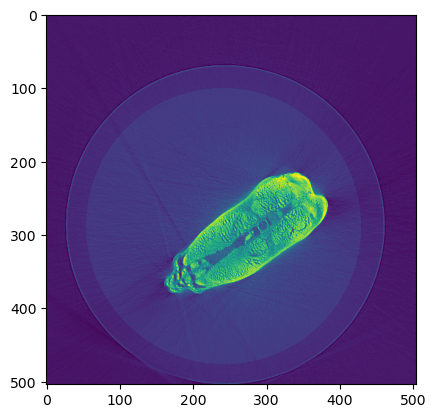

In [145]:
plt.imshow(image_data[int(d/2)])
plt.show()

## Transform

In [158]:
# Get landmarks info
land = read_mitk_landmarks(path_landmarks / str(ind), scale=1.0)

#print(land)

c = get_center(land)
print('Landmark center (x,y,z):', c)
print('Data size (x,y,z):', w,h,d)
print('Data center (x,y,z):', w/2,h/2,d/2)

#vec_norm, vec_land = create_two_vector_sets_v2(land) 
#res_rot = R.align_vectors(vec_land, vec_norm) 

# Find rotations
#rotation_degrees = res_rot[0].as_euler('zyx', degrees=True)
#print(f'{dataset}: Calculated rotations OLD:', rotation_degrees)
#degrees = -rotation_degrees

vec_norm, vec_land = creat_two_vectors_3axis(land)
res_rot = R.align_vectors(vec_land, vec_norm)
# Find rotations
rotation_degrees = res_rot[0].as_euler('zyx', degrees=True)

degrees = -rotation_degrees
print(f'{dataset}: Calculated rotations NEW:', degrees)


# Manual: z,y,x
#degrees = [168,-3,-14]

rot_x = degrees[2]
rot_y = degrees[1]
rot_z = degrees[0]


Landmark center (x,y,z): [ 253.82408944  288.50842781 1203.88176263]
Data size (x,y,z): 504 504 1604
Data center (x,y,z): 252.0 252.0 802.0
Center simple: [ 253.82408944  288.50842781 1203.88176263]
x: [-0.53356151 -0.83729592 -0.11936359]
y: [-0.83545386  0.53578742 -0.12226483]
z: [-0.16426814 -0.03230152  0.9858867 ]
Medaka_1064_4-1: Calculated rotations NEW: [-142.67119619   12.40498412   14.43861284]


In [154]:

print(f'Rotations. z:{rot_z}, y:{rot_y}, x:{rot_x}')

img_translation = Affine(scales=[1.0, 1.0, 1.0], degrees=[0,0,0], translation=[d/2-c[2],h/2-c[1],w/2-c[0]], center='image')
img_translation_back = Affine(scales=[1.0, 1.0, 1.0], degrees=[0,0,0], translation=[-(d/2-c[2]),-(h/2-c[1]),-(w/2-c[0])], center='image')

img_rotation = Affine(scales=[1.0, 1.0, 1.0], degrees=degrees, translation=[0,0,0], center='image')

img_rotation_x = Affine(scales=[1.0, 1.0, 1.0], degrees=[0,0,rot_x], translation=[0,0,0],
                                      center='image')
img_rotation_y = Affine(scales=[1.0, 1.0, 1.0], degrees=[0,rot_y,0], translation=[0,0,0],
                                      center='image')
img_rotation_z = Affine(scales=[1.0, 1.0, 1.0], degrees=[rot_z,0,0], translation=[0,0,0],
                                      center='image')

print('Transforming...')

# Shift to the landmark center
image_trans = img_translation(np.expand_dims(image_data, axis=0))[0]
#image_trans = img_translation(np.expand_dims(image_data, axis=0))

#image_rotated = img_rotation(image_trans)[0] # Old

if True:
    print('Rotation 1')
    image_rotated_z = img_rotation_z(np.expand_dims(image_trans, axis=0))[0]
    del image_trans
    print('Rotation 2')
    image_rotated_zy = img_rotation_y(np.expand_dims(image_rotated_z, axis=0))[0]
    del image_rotated_z
    print('Rotation 3')
    image_rotated = img_rotation_x(np.expand_dims(image_rotated_zy, axis=0))[0]
    del image_rotated_zy

#print('Translate back')
#image_trans = img_translation_back(np.expand_dims(image_rotated, axis=0))[0]
#del image_rotated


#print('Image shape', image_trans.shape)
#print(image_trans.dtype)
                
print('OK')

Rotations. z:57.627834301686924, y:9.521300240953243, x:-1.9505105430320413
Transforming...
Rotation 1
Rotation 2
Rotation 3
OK


In [102]:
#im_res = np.rot90(image_rotated, axes=(1,2))

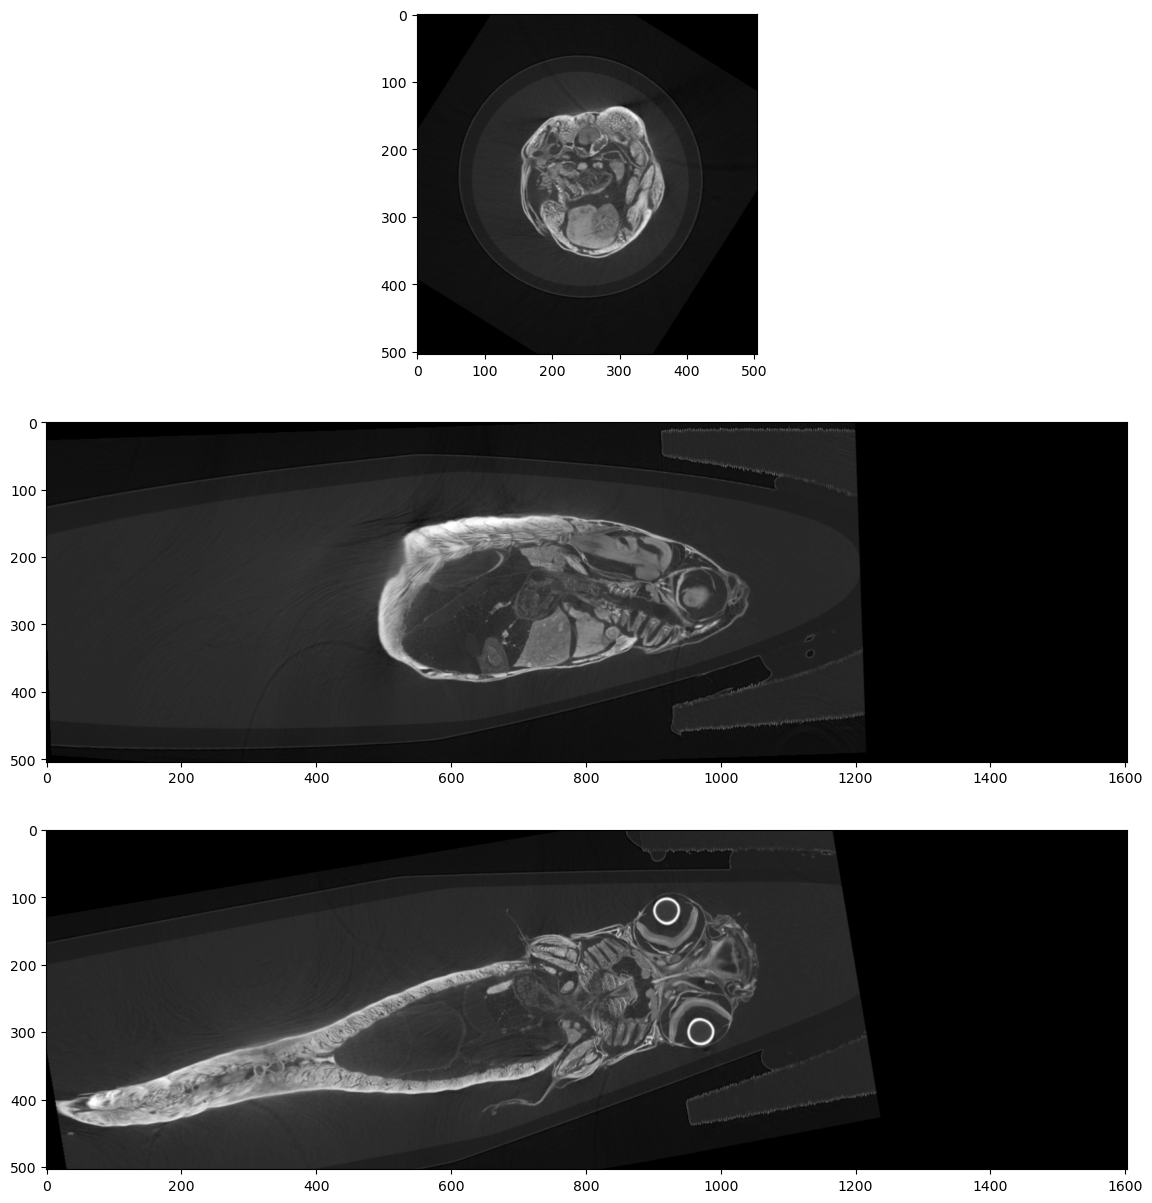

In [155]:
plot_volume_slices(image_rotated)

Reading image: Medaka_1064_4-1


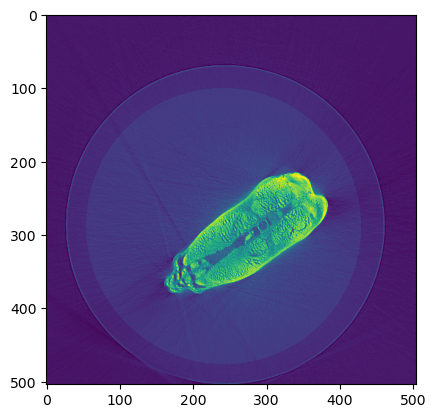

In [39]:
process_dataset(get_dataset_full_name(1064))

In [23]:
get_dataset_path(417)

['Medaka_800_4-1\n', 'Medaka_801_4-1\n', 'Medaka_802_4-2\n', 'Medaka_803_4-2\n', 'Medaka_804_4-2\n', 'Medaka_805_4-2\n', 'Medaka_806_7-2\n', 'Medaka_807_7-2\n', 'Medaka_808_7-2\n', 'Medaka_809_7-2\n', 'Medaka_810_7-2\n', 'Medaka_811_7-2\n', 'Medaka_812_7-2\n', 'Medaka_813_7-2\n', 'Medaka_814_8-2\n', 'Medaka_815_8-2\n', 'Medaka_816_8-2\n', 'Medaka_817_10-1\n', 'Medaka_818_10-1\n', 'Medaka_819_10-1\n', 'Medaka_820_10-1\n', 'Medaka_821_11-2\n', 'Medaka_822_11-2\n', 'Medaka_823_11-2\n', 'Medaka_824_11-2\n', 'Medaka_825_11-2\n', 'Medaka_826_11-2\n', 'Medaka_827_11-2\n', 'Medaka_828_11-2\n', 'Medaka_829_11-2\n', 'Medaka_830_13-2\n', 'Medaka_831_13-2\n', 'Medaka_832_13-2\n', 'Medaka_833_14-2\n', 'Medaka_834_14-2\n', 'Medaka_835_14-2\n', 'Medaka_836_15-1\n', 'Medaka_837_15-1\n', 'Medaka_838_15-1\n', 'Medaka_839_15-1\n', 'Medaka_840_15-1\n', 'Medaka_841_15-1\n', 'Medaka_842_17-1\n', 'Medaka_843_17-1\n', 'Medaka_844_17-1\n', 'Medaka_845_17-1\n', 'Medaka_846_17-1\n', 'Medaka_847_17-1\n', 'Medaka_

'/mnt/LSDF/projects/code-vita/Medaka/2018_11'

In [33]:
get_dataset_full_name(1064)

'Medaka_1064_4-1'

In [34]:
get_dataset_path(1064)

'/mnt/HD-LSDF/Medaka/201912_beamtime_medaka'